In [1]:
# directory = 'ML_Algorithms_FA_23/Federated_Learning_Project' ## This is the path to my directory, obvious apart from the drive/MyDrive

# from google.colab import drive ## We need to mount Google Drive to Colab's Virtual Machine
# drive.mount('/content/drive', force_remount=True) ## Once you try to mount the drive, you need to authorize it with your google account
# import os
# os.chdir('/content/drive/My Drive/' + directory) ## Now we just concatenate the drive to be in this specificed path

In [2]:
!pip install --quiet --upgrade yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 1.1 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import plotly.graph_objects as go
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Constants
SEQ_LEN = 60
EPOCHS = 60
BATCH_SIZE = 256
D_MODEL = 300
FUTURE_PERIOD = 10;

def fetch_stock_data(ticker_symbol):
    try:
        # Define the start and end dates
        start_date = datetime.datetime(2017, 1, 1)
        end_date = datetime.datetime.now()

        # Download stock data from start_date to end_date
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

        return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None

def process_data(df, SEQ_LEN, FUTURE_PERIOD):
    # Reverse the DataFrame if the dates are in descending order
    ## df = df.iloc[::-1]

    # Calculate the sizes for each dataset based on percentages
    test_size = int(0.1 * len(df))
    validation_size = int(0.2 * len(df))
    train_size = len(df) - test_size - validation_size

    # Adjust the sizes to account for SEQ_LEN and FUTURE_PERIOD
    train_size -= (SEQ_LEN + FUTURE_PERIOD - 1)
    validation_size -= (FUTURE_PERIOD - 1)

    # Split the dataframes based on the adjusted sizes
    train_df = df.iloc[:train_size]
    validation_df = df.iloc[train_size:train_size + validation_size]
    test_df = df.iloc[-test_size:]

    return train_df, validation_df, test_df

# Utility function to apply exponential moving average (EMA) to smooth out the data
def apply_ema(data, gamma=0.1):
    EMA = 0.0
    for ti in range(data.shape[0]):
        EMA = gamma * data[ti] + (1 - gamma) * EMA
        data[ti] = EMA
    return data

# Utility function to create the sequence data
def split_data(data, SEQ_LEN, FUTURE_PERIOD):
    X, Y = [], []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])  # Assuming column 3 is the 'Close' column
    return np.array(X), np.array(Y)

def preprocess_data(train_df, validation_df, test_df, SEQ_LEN, FUTURE_PERIOD=10):
    # Converting DataFrames to numpy arrays for the MinMaxScaler
    train_ = train_df.values
    valid_ = validation_df.values
    test_ = test_df.values

    # Extract date indices for each dataset
    train_dates = train_df.index
    valid_dates = validation_df.index
    test_dates = test_df.index

    # Setting up the MinMaxScaler and scaling the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_)
    valid_scaled = scaler.transform(valid_)
    test_scaled = scaler.transform(test_)

    # Apply EMA to smooth out the data
    train_scaled = apply_ema(train_scaled)

    # Splitting the data into features and target sets
    X_train, y_train = split_data(train_scaled, SEQ_LEN, FUTURE_PERIOD)
    X_valid, y_valid = split_data(valid_scaled, SEQ_LEN, FUTURE_PERIOD)
    X_test, y_test = split_data(test_scaled, SEQ_LEN, FUTURE_PERIOD)

    # Reshaping the input to be compatible with LSTM (if needed)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    return (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), scaler

def plot_stock_data(company, df, X_train, y_train, X_valid, y_valid, X_test, y_test, SEQ_LEN):
    # Calculate the start index for each set
    train_start_idx = SEQ_LEN
    valid_start_idx = len(X_train) + SEQ_LEN
    test_start_idx = len(X_train) + len(X_valid) + SEQ_LEN

    # Select the corresponding dates for each dataset
    train_dates = df.index[train_start_idx:train_start_idx + len(X_train)]
    valid_dates = df.index[valid_start_idx:valid_start_idx + len(X_valid)]
    test_dates = df.index[test_start_idx:test_start_idx + len(X_test)]

    # Create plot traces
    trace_train = go.Scatter(x=train_dates, y=y_train.flatten(), mode='lines', name='Train Target', line=dict(color='blue'))
    trace_valid = go.Scatter(x=valid_dates, y=y_valid.flatten(), mode='lines', name='Validation Target', line=dict(color='gray'))
    trace_test = go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Test Target', line=dict(color='black'))

    # Define the layout
    layout = go.Layout(
        title=f'Train, Validation, and Test Targets for {company}',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Normalized Price'),
        hovermode='closest'
    )

    # Construct and show the figure
    fig = go.Figure(data=[trace_train, trace_valid, trace_test], layout=layout)
    fig.show()

def main():
#     companies = ["AMD", "ATVI", "AAL", "BB", "CCL", "DBX", "F", "GPS", "HPE", "INTC",
#                  "JBLU", "KSS", "LEVI", "M", "NOK", "ODP", "PFE", "QCOM", "LUV",
#                  "UA", "WBA", "XRX", "YUM", "GRPN"]

    companies = ["TSLA", "AAPL", "ABNB", "FDX", "NVDA", "ORCL", "GOOG", "AMZN", "MSFT", "IBM"]

    all_processed_data = {}

    for company in companies:
        stock_data = fetch_stock_data(company)
        if stock_data is not None:
            train_df, validation_df, test_df = process_data(stock_data, SEQ_LEN, FUTURE_PERIOD)
            processed_data = preprocess_data(train_df, validation_df, test_df, SEQ_LEN)
            all_processed_data[company] = (processed_data, stock_data)  # Include stock_data in all_processed_data

    # Now iterate over each company and plot its data
    for company, (data, stock_data) in all_processed_data.items():
        (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), company_scaler = data
        plot_stock_data(company, stock_data, X_train, y_train, X_valid, y_valid, X_test, y_test, SEQ_LEN)

    return None

main()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D,
    concatenate, Dense, Layer, Dropout, Lambda, Activation, TimeDistributed, Add, Conv1D
)
from tensorflow.keras.initializers import Ones, Zeros
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1_l2

In [5]:
# Custom Learning Rate Scheduler
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is float
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)
            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)

            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]])
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)
                ks = self.ks_layers[i](k)
                vs = self.vs_layers[i](v)
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x)
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    def GetPosEncodingMatrix(max_len, d_emb):
        pos_enc = np.array([
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0 else np.zeros(d_emb)
            for pos in range(max_len)
            ])
        pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
        pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
        return pos_enc

    def GetPadMask(q, k):
        ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
        mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
        mask = K.batch_dot(ones, mask, axes=[2,1])
        return mask

    def GetSubMask(s):
        len_s = tf.shape(s)[1]
        bs = tf.shape(s)[:1]
        mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
        return mask

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Training model for TSLA...
Epoch 1/60
5/5 [==============================] - 24s 3s/step - loss: 0.5241 - val_loss: 0.4143
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.5070 - val_loss: 0.4219
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.4669 - val_loss: 0.4349
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 0.4226 - val_loss: 0.4537


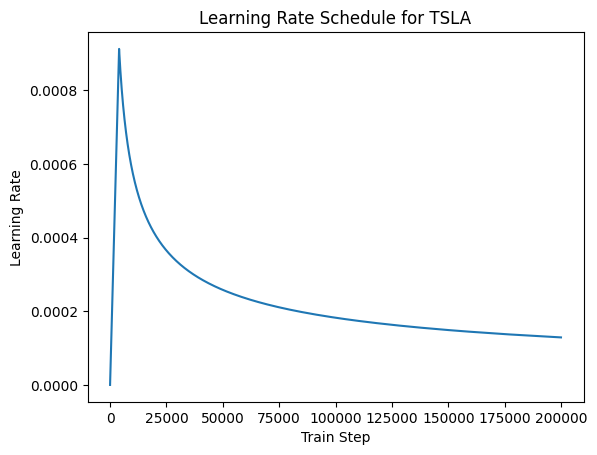

Training model for AAPL...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.3610 - val_loss: 0.5652
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.3536 - val_loss: 0.5698
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.3455 - val_loss: 0.5741
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 0.3337 - val_loss: 0.5658


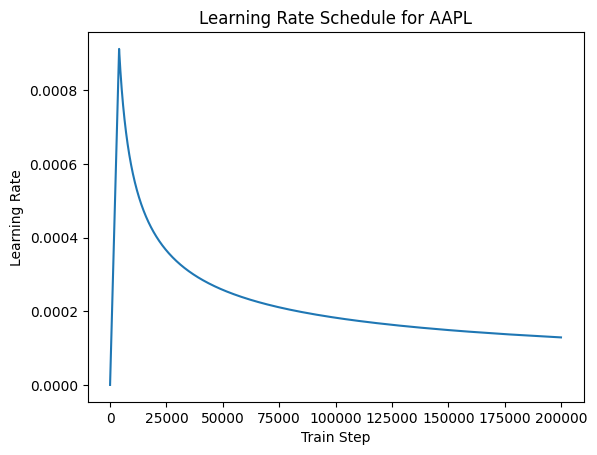

Training model for ABNB...
Epoch 1/60
2/2 [==============================] - 16s 3s/step - loss: 0.3265 - val_loss: 0.2388
Epoch 2/60
2/2 [==============================] - 4s 2s/step - loss: 0.3250 - val_loss: 0.2386
Epoch 3/60
2/2 [==============================] - 4s 2s/step - loss: 0.3217 - val_loss: 0.2382
Epoch 4/60
2/2 [==============================] - 5s 1s/step - loss: 0.3300 - val_loss: 0.2377
Epoch 5/60
2/2 [==============================] - 4s 1s/step - loss: 0.3198 - val_loss: 0.2371
Epoch 6/60
2/2 [==============================] - 4s 1s/step - loss: 0.3219 - val_loss: 0.2366
Epoch 7/60
2/2 [==============================] - 5s 2s/step - loss: 0.3208 - val_loss: 0.2362
Epoch 8/60
2/2 [==============================] - 4s 1s/step - loss: 0.3176 - val_loss: 0.2361
Epoch 9/60
2/2 [==============================] - 4s 1s/step - loss: 0.3067 - val_loss: 0.2364
Epoch 10/60
2/2 [==============================] - 4s 2s/step - loss: 0.3051 - val_loss: 0.2370
Epoch 11/60
2/2 [====

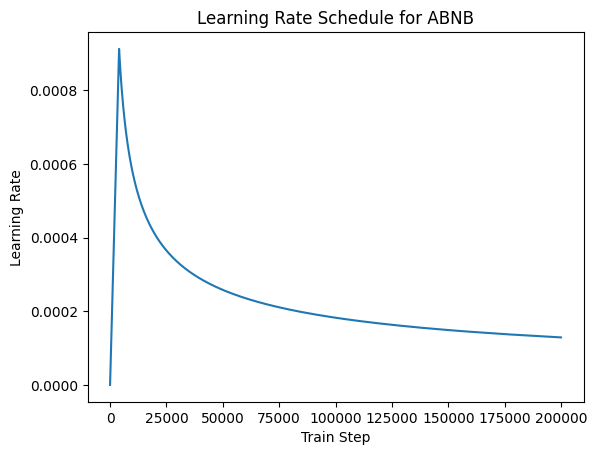

Training model for FDX...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.4788 - val_loss: 0.4346
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.4737 - val_loss: 0.4254
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.4577 - val_loss: 0.4081
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 0.4390 - val_loss: 0.3810
Epoch 5/60
5/5 [==============================] - 11s 2s/step - loss: 0.4215 - val_loss: 0.3436
Epoch 6/60
5/5 [==============================] - 11s 2s/step - loss: 0.3825 - val_loss: 0.2989
Epoch 7/60
5/5 [==============================] - 11s 2s/step - loss: 0.3528 - val_loss: 0.2640
Epoch 8/60
5/5 [==============================] - 10s 2s/step - loss: 0.3283 - val_loss: 0.2525
Epoch 9/60
5/5 [==============================] - 11s 2s/step - loss: 0.3293 - val_loss: 0.2595
Epoch 10/60
5/5 [==============================] - 11s 2s/step - loss: 0.3279 - val_loss: 0.2618
Epoch 11/60
5

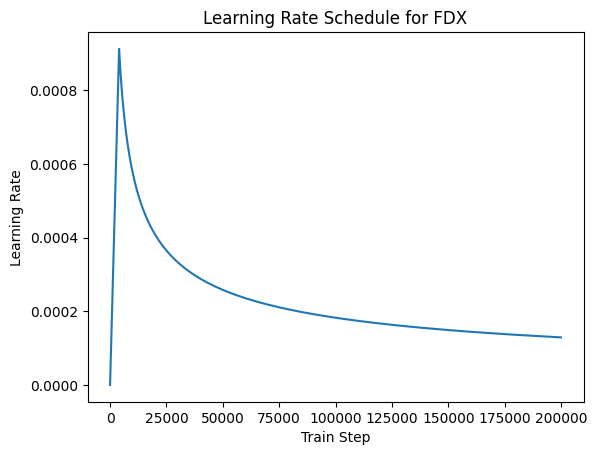

Training model for NVDA...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.3212 - val_loss: 0.7503
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.3205 - val_loss: 0.7314
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.3175 - val_loss: 0.6967
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 0.3119 - val_loss: 0.6452
Epoch 5/60
5/5 [==============================] - 12s 2s/step - loss: 0.3082 - val_loss: 0.5840
Epoch 6/60
5/5 [==============================] - 13s 2s/step - loss: 0.3005 - val_loss: 0.5188
Epoch 7/60
5/5 [==============================] - 11s 2s/step - loss: 0.2877 - val_loss: 0.4590
Epoch 8/60
5/5 [==============================] - 11s 2s/step - loss: 0.2788 - val_loss: 0.4203
Epoch 9/60
5/5 [==============================] - 11s 2s/step - loss: 0.2745 - val_loss: 0.3861
Epoch 10/60
5/5 [==============================] - 10s 2s/step - loss: 0.2637 - val_loss: 0.3639
Epoch 11/60


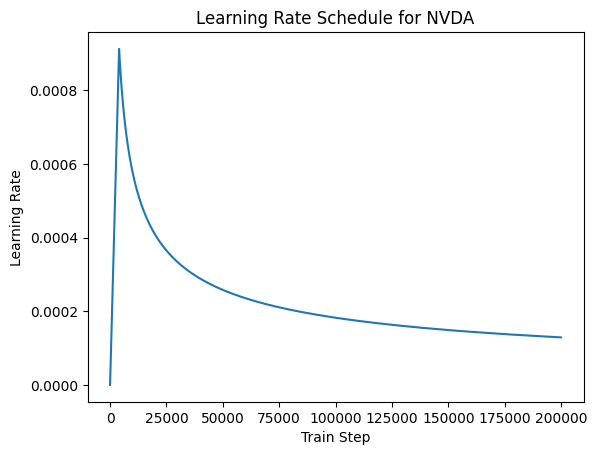

Training model for ORCL...
Epoch 1/60
5/5 [==============================] - 25s 3s/step - loss: 0.4171 - val_loss: 0.2638
Epoch 2/60
5/5 [==============================] - 10s 2s/step - loss: 0.4141 - val_loss: 0.2716
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.3802 - val_loss: 0.2894
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 0.3583 - val_loss: 0.3231


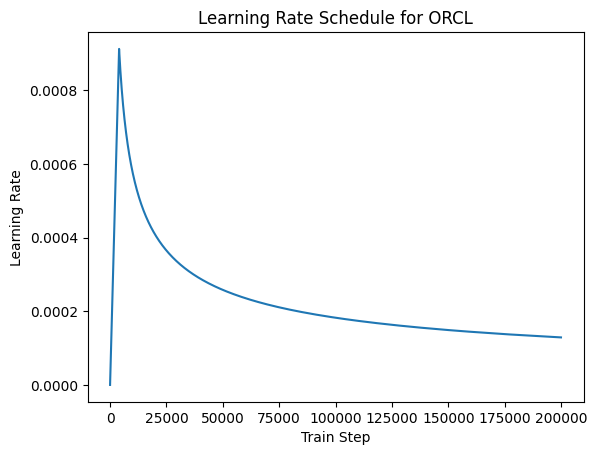

Training model for GOOG...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.3149 - val_loss: 0.3174
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.3097 - val_loss: 0.3261
Epoch 3/60
5/5 [==============================] - 10s 2s/step - loss: 0.2963 - val_loss: 0.3404
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 0.2882 - val_loss: 0.3578


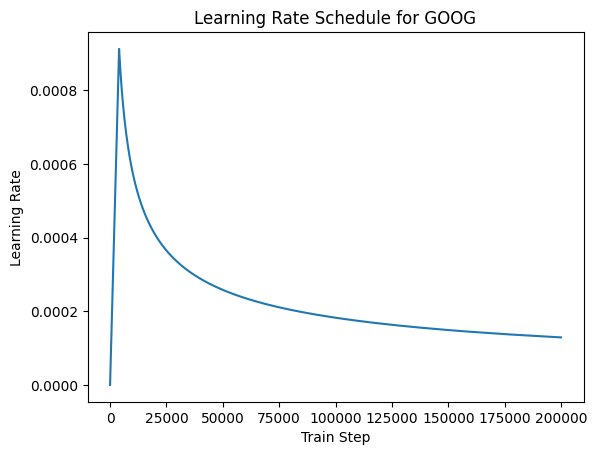

Training model for AMZN...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.4088 - val_loss: 0.4890
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.4023 - val_loss: 0.4744
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.3943 - val_loss: 0.4485
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 0.3854 - val_loss: 0.4108
Epoch 5/60
5/5 [==============================] - 10s 2s/step - loss: 0.3682 - val_loss: 0.3620
Epoch 6/60
5/5 [==============================] - 11s 2s/step - loss: 0.3438 - val_loss: 0.3143
Epoch 7/60
5/5 [==============================] - 11s 2s/step - loss: 0.3219 - val_loss: 0.2788
Epoch 8/60
5/5 [==============================] - 11s 2s/step - loss: 0.3105 - val_loss: 0.2632
Epoch 9/60
5/5 [==============================] - 10s 2s/step - loss: 0.3052 - val_loss: 0.2590
Epoch 10/60
5/5 [==============================] - 10s 2s/step - loss: 0.2894 - val_loss: 0.2579
Epoch 11/60


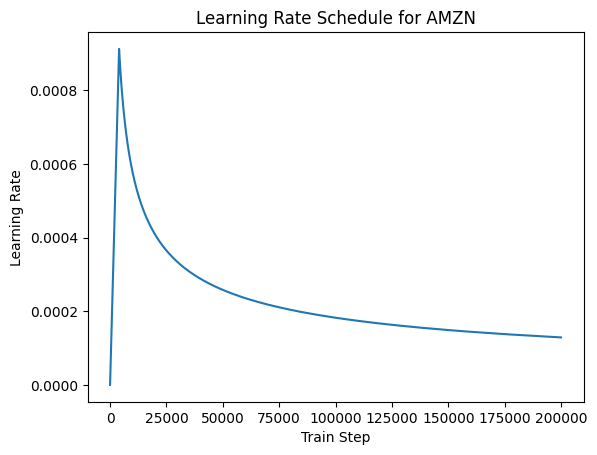

Training model for MSFT...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.4163 - val_loss: 0.3525
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.4038 - val_loss: 0.3654
Epoch 3/60
5/5 [==============================] - 10s 2s/step - loss: 0.3972 - val_loss: 0.3880
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 0.3599 - val_loss: 0.4209


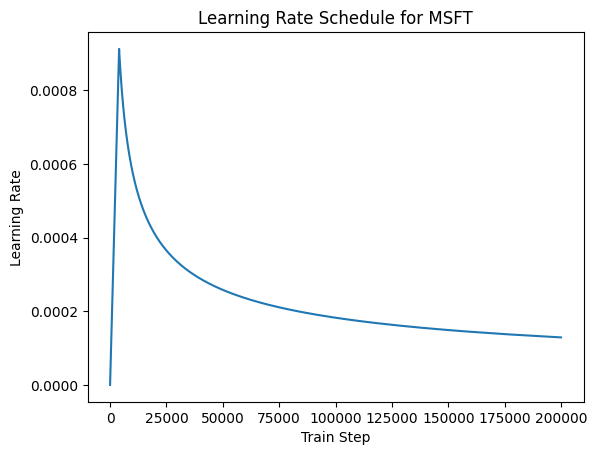

Training model for IBM...
Epoch 1/60
5/5 [==============================] - 23s 3s/step - loss: 0.3937 - val_loss: 0.4216
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 0.3885 - val_loss: 0.4163
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 0.3765 - val_loss: 0.4065
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 0.3506 - val_loss: 0.3911
Epoch 5/60
5/5 [==============================] - 11s 2s/step - loss: 0.3250 - val_loss: 0.3685
Epoch 6/60
5/5 [==============================] - 11s 2s/step - loss: 0.2977 - val_loss: 0.3390
Epoch 7/60
5/5 [==============================] - 11s 2s/step - loss: 0.2771 - val_loss: 0.3054
Epoch 8/60
5/5 [==============================] - 11s 2s/step - loss: 0.2759 - val_loss: 0.2836
Epoch 9/60
5/5 [==============================] - 10s 2s/step - loss: 0.2805 - val_loss: 0.2789
Epoch 10/60
5/5 [==============================] - 11s 2s/step - loss: 0.2767 - val_loss: 0.2870
Epoch 11/60
5

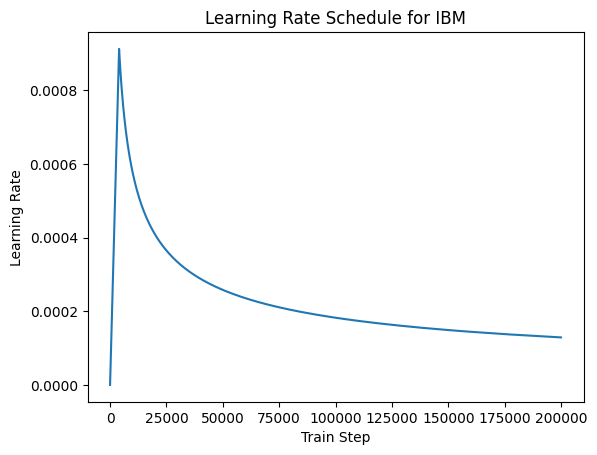

CPU times: user 31min 28s, sys: 1min 29s, total: 32min 58s
Wall time: 24min 13s


In [10]:
%%time

def main_func2():
#     companies = ["AMD", "ATVI", "AAL", "BB", "CCL", "DBX", "F", "GPS", "HPE", "INTC",
#                  "JBLU", "KSS", "LEVI", "M", "NOK", "ODP", "PFE", "QCOM", "LUV",
#                  "UA", "WBA", "XRX", "YUM", "GRPN"]

    companies = ["TSLA", "AAPL", "ABNB", "FDX", "NVDA", "ORCL", "GOOG", "AMZN", "MSFT", "IBM"]

    all_processed_data = {}

    for company in companies:
        stock_data = fetch_stock_data(company)
        if stock_data is not None:
            train_df, validation_df, test_df = process_data(stock_data, SEQ_LEN, FUTURE_PERIOD)
            processed_data = preprocess_data(train_df, validation_df, test_df, SEQ_LEN)
            all_processed_data[company] = processed_data

    return all_processed_data

# Execute the main function
all_data = main_func2()

# Build the combined LSTM and Transformer model
def build_model(seq_len, feature_dim):
    inp = Input(shape=(seq_len, feature_dim))

    # Adding L1/L2 regularization to LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                           recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(inp)
    x = Dropout(0.3)(x)  # Adding dropout for regularization
    x = Bidirectional(LSTM(64, return_sequences=True,
                           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                           recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(x)
    x = Dropout(0.3)(x)  # Adding dropout for regularization

    # Transformer layer (assuming EncoderLayer is defined correctly)
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512,
            n_head=4,
            d_k=64,
            d_v=64,
            dropout=0.2)(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    conc = Dropout(0.3)(conc)  # Adding dropout here as well
    x = Dense(1, activation="sigmoid", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(conc)

    model = Model(inputs=inp, outputs=x)
    return model

## add more dropouts
## weight decay, add regularization terms (may help)

# Initialize the learning rate scheduler
lr_schedule = CustomeLearningSchedule(D_MODEL)

# Dictionary to store the best models for each company
best_models = {}

for company in all_data:
    print(f"Training model for {company}...")

    # Accessing and shuffling data for the current company
    (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), company_scaler = all_data[company]
    X_train, y_train = shuffle(X_train, y_train)

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Build and compile the model for the current company
    multi_head = build_model(SEQ_LEN, X_train.shape[2])
    multi_head.compile(loss="mean_squared_error", optimizer=optimizer)

    # Training the model for the current company
    history = multi_head.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_valid, y_valid),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    # Store the model with the best weights for the current company
    best_models[company] = multi_head

    # Plotting the learning rate schedule
    steps = tf.range(200000, dtype=tf.float32)
    plt.plot(lr_schedule(steps))
    plt.ylabel("Learning Rate")
    plt.xlabel("Train Step")
    plt.title(f'Learning Rate Schedule for {company}')
    plt.show()

In [7]:
# tf.keras.utils.plot_model(multi_head, to_file="LSTM_Architecture/multi_head_net.png", show_shapes=True)

In [11]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Constants
SEQ_LEN = 60
# Assuming num_features will be determined for each company dataset

for company in all_data.keys():
    print(f"Predicting and plotting for {company}...")

    # Accessing data for the current company
    (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), scaler = all_data[company]

    num_features = X_train.shape[2]  # Determine num_features based on current company's dataset

    # Predict with the best model for the current company
    predicted_stock_price = best_models[company].predict(X_test)

    # Rescale the predictions and actual values
    dummy_data = np.zeros((predicted_stock_price.shape[0], num_features))
    dummy_data[:, 0] = predicted_stock_price.flatten()
    predicted_stock_price_rescaled = scaler.inverse_transform(dummy_data)[:, 0]

    dummy_data_test = np.zeros((y_test.shape[0], num_features))
    dummy_data_test[:, 0] = y_test.flatten()
    y_test_rescaled = scaler.inverse_transform(dummy_data_test)[:, 0]

    # Use the test dates extracted from all_data for plotting
    # test_dates variable already holds the date information

    # Plotting the results
    trace1 = go.Scatter(x=test_dates, y=y_test_rescaled.flatten(), mode='lines', name='Actual Stock Price')
    trace2 = go.Scatter(x=test_dates, y=predicted_stock_price_rescaled.flatten(), mode='lines', name='Predicted Stock Price')

    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=1, col=1)

#     fig.update_layout(title=f'{company} Stock Price Prediction', xaxis_title='Date', yaxis_title='Stock Price')
#     fig.write_html(f'./Forecasts/{company}_stock_price_prediction.html')
    fig.show()

Predicting and plotting for TSLA...
4/4 [==============================] - 3s 144ms/step


Predicting and plotting for AAPL...
4/4 [==============================] - 4s 81ms/step


Predicting and plotting for ABNB...
1/1 [==============================] - 2s 2s/step


Predicting and plotting for FDX...
4/4 [==============================] - 3s 84ms/step


Predicting and plotting for NVDA...


4/4 [==============================] - 2s 93ms/step


Predicting and plotting for ORCL...


4/4 [==============================] - 2s 90ms/step


Predicting and plotting for GOOG...
4/4 [==============================] - 2s 94ms/step


Predicting and plotting for AMZN...
4/4 [==============================] - 2s 86ms/step


Predicting and plotting for MSFT...
4/4 [==============================] - 3s 157ms/step


Predicting and plotting for IBM...
4/4 [==============================] - 2s 86ms/step


## Getting the Accuracy Score (RSquare and MSE)

In [12]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Constants
SEQ_LEN = 90
# Assuming num_features will be determined for each company dataset

r2_scores = {}
mse_scores = {}

for company in all_data.keys():
    print(f"Predicting and plotting for {company}...")

    # Accessing data for the current company
    (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), scaler = all_data[company]

    num_features = X_train.shape[2]  # Determine num_features based on current company's dataset

    # Predict with the best model for the current company
    predicted_stock_price = best_models[company].predict(X_test)

    # Rescale the predictions and actual values
    dummy_data = np.zeros((predicted_stock_price.shape[0], num_features))
    dummy_data[:, 0] = predicted_stock_price.flatten()
    predicted_stock_price_rescaled = scaler.inverse_transform(dummy_data)[:, 0]

    dummy_data_test = np.zeros((y_test.shape[0], num_features))
    dummy_data_test[:, 0] = y_test.flatten()
    y_test_rescaled = scaler.inverse_transform(dummy_data_test)[:, 0]

    # Use the test dates extracted from all_data for plotting
    # test_dates variable already holds the date information

    # Plotting the results
    trace1 = go.Scatter(x=test_dates, y=y_test_rescaled.flatten(), mode='lines', name='Actual Stock Price')
    trace2 = go.Scatter(x=test_dates, y=predicted_stock_price_rescaled.flatten(), mode='lines', name='Predicted Stock Price')

    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=1, col=1)

#     fig.update_layout(title=f'{company} Stock Price Prediction', xaxis_title='Date', yaxis_title='Stock Price')
#     fig.write_html(f'./Forecasts/{company}_stock_price_prediction.html')
    fig.show()
    # Calculate R^2 and MSE scores
    r2_score_company = r2_score(y_test_rescaled, predicted_stock_price_rescaled)
    mse_score_company = mean_squared_error(y_test_rescaled, predicted_stock_price_rescaled)

    # Storing the scores in dictionaries
    r2_scores[company] = r2_score_company
    mse_scores[company] = mse_score_company

    # Print the scores
    print(f"{company} - R^2 Score: {r2_score_company:.3f}, MSE: {mse_score_company:.3f}")

# Optionally, display the scores for each company in a more structured format, like a DataFrame
import pandas as pd

scores_df = pd.DataFrame({'R2 Score': r2_scores, 'MSE': mse_scores})
print(scores_df)

Predicting and plotting for TSLA...
4/4 [==============================] - 0s 98ms/step


TSLA - R^2 Score: -22.861, MSE: 7007.547
Predicting and plotting for AAPL...
4/4 [==============================] - 0s 91ms/step


AAPL - R^2 Score: -139.918, MSE: 9089.977
Predicting and plotting for ABNB...
1/1 [==============================] - 0s 49ms/step


ABNB - R^2 Score: -36.500, MSE: 149.456
Predicting and plotting for FDX...
4/4 [==============================] - 0s 88ms/step


FDX - R^2 Score: -19.820, MSE: 2330.846
Predicting and plotting for NVDA...
4/4 [==============================] - 0s 101ms/step


NVDA - R^2 Score: -96.360, MSE: 73187.293
Predicting and plotting for ORCL...
4/4 [==============================] - 0s 94ms/step


ORCL - R^2 Score: -47.874, MSE: 1863.265
Predicting and plotting for GOOG...
4/4 [==============================] - 0s 92ms/step


GOOG - R^2 Score: -87.661, MSE: 1732.782
Predicting and plotting for AMZN...
4/4 [==============================] - 0s 86ms/step


AMZN - R^2 Score: -0.099, MSE: 79.289
Predicting and plotting for MSFT...
4/4 [==============================] - 0s 93ms/step


MSFT - R^2 Score: -44.398, MSE: 23149.580
Predicting and plotting for IBM...
4/4 [==============================] - 0s 95ms/step


IBM - R^2 Score: -0.065, MSE: 71.802
        R2 Score           MSE
TSLA  -22.860748   7007.547065
AAPL -139.917591   9089.977066
ABNB  -36.499906    149.455586
FDX   -19.819904   2330.846174
NVDA  -96.360296  73187.292713
ORCL  -47.874222   1863.265351
GOOG  -87.660718   1732.781506
AMZN   -0.098533     79.289255
MSFT  -44.397697  23149.579777
IBM    -0.065055     71.801894


# Federated Learning Implementation